# Symmetrical Operational Amplifier

Here we shall use the models obtained from `eq_mapping_demo` and size the Symmetrical OP shown below

![](https://raw.githubusercontent.com/AugustUnderground/smacd2021-b4.4/0a72aa681382dfdbaa185a33c2868aca6cc498c8/notebooks/fig/sym.png)


## Requirements

This requires [AC²E](https://github.com/matthschw/ace) and [HAC²E](https://github.com/AugustUnderground/hace) to be setup correctly.

In [1]:
import os, datetime, time, sys
import numpy as np
import torch as pt
import pandas as pd
import joblib as jl
import hace as ac
from functools import partial
from expression import compose, pipe
from skopt import gp_minimize, forest_minimize, gbrt_minimize, dummy_minimize
from skopt import dump, load
from skopt.space import Real
from skopt.utils import use_named_args
from skopt.plots import plot_convergence, plot_objective, plot_evaluations, plot_regret
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, minmax_scale
from fastprogress.fastprogress import master_bar, progress_bar

In [2]:
class PlasmaModel:
    def __init__(self, path: str, params_x: [str], params_y: [str], trafo_x: [str], trafo_y: [str]):
        self.params_x = params_x
        self.params_y = params_y
        
        self.mask_x   = np.array([int(px in trafo_x) for px in self.params_x])
        self.mask_y   = np.array([int(py in trafo_y) for py in self.params_y])
        
        self.scaler_x = jl.load(f"{path}/scale.X")
        self.scaler_y = jl.load(f"{path}/scale.Y")
        self.scale_x  = lambda X: self.scaler_x.transform(X)
        self.scale_y  = lambda Y: self.scaler_y.inverse_transform(Y)
        
        self.trafo_x  = lambda X: (np.log10(np.abs(X), where = (np.abs(X) > 0)) * self.mask_x) + (X * (1 - self.mask_x))
        self.trafo_y  = lambda Y: (np.power(10, Y) * self.mask_y) + (Y * (1 - self.mask_y))
        
        self.model    = pt.jit.load(f"{path}/model.pt").cpu().eval()
    
    def _predict(self, X: np.array) -> np.array:
        with pt.no_grad():
            return pipe( X
                       , self.trafo_x
                       , self.scale_x
                       , np.float32
                       , pt.from_numpy
                       , self.model
                       , pt.Tensor.numpy
                       , self.scale_y
                       , self.trafo_y
                       , )
        
    def predict(self, X: pd.DataFrame) -> pd.DataFrame:
        Y = pd.DataFrame( self._predict(X[self.params_x].values)
                        , columns = self.params_y ).dropna()
        return Y

## Setup

Here we setup the circuit and device equation models

In [3]:
technology  = "xh035"

ace_id      = "op2"                 # ACE ID for Symmetrical Amplifier
ace_backend = f"{technology}-3V3"   # Backend should correspond to PDK used for equation models

nmos_path   = f"./models/eq-20220127-070528-nmos-{technology}"
pmos_path   = f"./models/eq-20220127-072759-pmos-{technology}"

params_x    = ["gmoverid", "fug", "Vds", "Vbs"]
params_y    = ["idoverw", "L", "gdsoverw", "Vgs"]

trafo_x     = ["fug"]
trafo_y     = ["idoverw", "gdsoverw"]

devices     = ["MNCM11", "MNCM31", "MND11", "MPCM221"]
branches    = ["IB1", "IB2"]

In [4]:
sym_amp = ac.make_env(ace_id, ace_backend)

In [5]:
nmos = PlasmaModel(nmos_path, params_x, params_y, trafo_x, trafo_y)
pmos = PlasmaModel(pmos_path, params_x, params_y, trafo_x, trafo_y)
γ_n  = nmos.predict
γ_p  = pmos.predict

## Sizing

In the circuit we have 5 _building blocks_ where the PMOS current mirrors `MPCMXXX` 
are sized identically leaving us with 4 reference devices that need to be sized:

1. `MNCM11`
1. `MNCM31`
1. `MPCM221`
1. `MND11`

As sucht, we get to choose 4 $\frac{g_{\mathrm{m}}}{I_{\mathrm{d}}}$s, 4 $f_{\mathrm{ug}}$s 
and the branch currents $I_{\mathtt{B1}}$ and $I_{\mathtt{B2}}$.

### Specification

We consider the following values given, i.e. knowledge about the design we have _a priori_.

| Parameter             | Specification       |
|:----------------------|--------------------:|
| $V_{\mathrm{DD}}$     | $1.8\,\mathrm{V}$   |
| $V_{\mathrm{in,cm}}$  | $0.9\,\mathrm{V}$   |
| $V_{\mathrm{out,cm}}$ | $0.9\,\mathrm{V}$   |
| $I_{\mathtt{B0}}$     | $5\,\mathrm{\mu A}$ |
| $C_{\mathtt{L}}$      | $10\,\mathrm{pF}$   |

Instead of specifying a target performance from the get go, we shall formulate a sizing 
procedure that can be executed for arbitrary target performances.
We should end up with a function, that maps the electrical characteristics of the 4 _reference devices_ 
listed above and the 2 branch currents to desired performance parameters.

$$
\begin{bmatrix}
\frac{g_{\mathrm{m}}}{I_{\mathrm{d}}}_{\mathtt{MNCM11}} \\
\frac{g_{\mathrm{m}}}{I_{\mathrm{d}}}_{\mathtt{MNCM31}} \\
\frac{g_{\mathrm{m}}}{I_{\mathrm{d}}}_{\mathtt{MPCM221}} \\
\frac{g_{\mathrm{m}}}{I_{\mathrm{d}}}_{\mathtt{MND11}} \\
f_{\mathrm{ug}, \mathtt{MNCM11}} \\
f_{\mathrm{ug}, \mathtt{MNCM31}} \\
f_{\mathrm{ug}, \mathtt{MPCM221}} \\
f_{\mathrm{ug}, \mathtt{MND11}} \\
I_{\mathtt{B1}} \\
I_{\mathtt{B2}}
\end{bmatrix}
\mapsto
\begin{bmatrix}
A_{0} \\
UGBW \\
\vdots
\end{bmatrix}
$$

In combination with a suitable cost/loss function this will be our optimization objective. 
For simplicity we will only consider the DC gain $A_{0}$ and the Unity Gain Bandwidth $UGBW$ in this demo.

In [6]:
V_DD = ac.current_parameters(sym_amp)["vsup"]
I_B0 = ac.current_parameters(sym_amp)["i0"]
C_L  = ac.current_parameters(sym_amp)["cl"]
R_L  = ac.current_parameters(sym_amp)["rl"]

### Simplification

Some designers prefer to fix certain electrical characteristics of devices. For this example we will fix $\frac{g_{\mathrm{m}}}{I_{\mathrm{d}}} = 10\,\mathrm{V}^{-1}$.
Additionally, we will choose the branch currents instead of leaving them as design objectives.

In [7]:
I_B1             = 6e-6
I_B2             = 12e-6
#gmoverid_MNCM11  = 10.0
#gmoverid_MNCM31  = 10.0
#gmoverid_MPCM221 = 10.0
#gmoverid_MND11   = 10.0

### Sizing Procedure

In [8]:
def sizing_procedure( I_B0, I_B1, I_B2
                    , gmoverid_MNCM11, gmoverid_MNCM31, gmoverid_MND11, gmoverid_MPCM221
                    , fug_MNCM11     , fug_MNCM31     , fug_MND11     , fug_MPCM221      ):

    nmos_input = pd.DataFrame( np.array([ [gmoverid_MNCM11, fug_MNCM11, V_DD / 4.0, 0.0]
                                        , [gmoverid_MNCM31, fug_MNCM31, V_DD / 4.0, 0.0]
                                        , [gmoverid_MND11 , fug_MND11 , V_DD / 2.0, -(V_DD / 4)] ])
                             , columns = params_x )

    pmos_input = pd.DataFrame( np.array([ [gmoverid_MPCM221, fug_MPCM221, V_DD / 3.0, 0.0] ])
                             , columns = params_x )

    nmos_output = γ_n(nmos_input)
    pmos_output = γ_p(pmos_input)

    design_data = pd.concat( [ pd.concat( [nmos_input , pmos_input], ignore_index = True
                                        ).rename(index = dict(zip(range(4), devices)))
                             , pd.concat( [nmos_output, pmos_output], ignore_index = True
                                        ).rename(index = dict(zip(range(4), devices))) ]
                           , axis = 1 )

    Mcm11 = 1
    Mcm12 = I_B1 // I_B0
    Wcm1  = I_B0 / design_data.loc["MNCM11"]["idoverw"]
    Lcm1  = design_data.loc["MNCM11"]["L"]

    Mcm21 = 1
    Mcm22 = (I_B2 * 2) // I_B1
    Wcm2  = (I_B1/2) / design_data.loc["MPCM221"]["idoverw"]
    Lcm2  = design_data.loc["MPCM221"]["L"]

    Mcm31 = 2
    Mcm32 = Mcm31
    Wcm3  = (I_B2 / design_data.loc["MNCM31"]["idoverw"]) / Mcm31
    Lcm3  = design_data.loc["MNCM31"]["L"]
    
    Md    = 2
    Wd    = ((I_B1/2) / design_data.loc["MND11"]["idoverw"]) / Md
    Ld    = design_data.loc["MND11"]["L"]

    sizing = { 'Wd':   Wd  , 'Ld':   Ld  , 'Md':    Md
             , 'Wcm1': Wcm1, 'Lcm1': Lcm1, 'Mcm11': Mcm11, 'Mcm12': Mcm12
             , 'Wcm2': Wcm2, 'Lcm2': Lcm2, 'Mcm21': Mcm21, 'Mcm22': Mcm22
             , 'Wcm3': Wcm3, 'Lcm3': Lcm3, 'Mcm31': Mcm31, 'Mcm32': Mcm32 }

    return sizing

## Design Objective Optimization

In [9]:
branches     = [ Real(name = f"I_B1", low = 3.0, high = 15.0)
               , Real(name = f"I_B2", low = 3.0, high = 30.0) ]
gmids        = [ Real(name = f"gmoverid_{d}", low = 5.0, high = 25.0) 
                 for d in devices ]
fugs         = [ Real(name = f"fug_{d}", low = 6.0, high = 9.0) 
                 for d in devices ]
design_space = gmids + fugs # + branches

### Target Specification

Example target specification 

| Target                 | Specification                           |
|:-----------------------|----------------------------------------:|
| DC Gain                | $60\,\mathrm{dB}$                       |
| Unity Gain Bandwidth   | $7.5\,\mathrm{MHz}$                     |
| Common Mode Rejectinon | $80.0\,\mathrm{dB}$                     |
| Power Supply Rejection | $60\,\mathrm{dB}$, $90\,\mathrm{dB}$    |
| Slew Rate              | $3.8\,\frac{\mathrm{V}}{\mu\mathrm{s}}$ |
| Phase Margin           | $42^{\circ}$                            |
| Gain Margin            | $-20\,\mathrm{dB}$                      |
| Offset                 | $0\,\mathrm{V}$                         |


In [10]:
target = { 'a_0':       60.0
         , 'ugbw':      7500000.0
         , 'cmrr':      80.0
         , 'psrr_n':    60.0
         , 'psrr_p':    90.0
         , 'sr_r':      3800000.0
         , 'sr_f':     -3800000.0
         , 'pm':        42.0
         , 'gm':       -20.0
         , 'voff_stat': 0.0
         , 'voff_sys':  0.0 }

### Loss Function

In [11]:
def losses(t, p):
    a = lambda x,y: (x - np.nan_to_num(y)) / (x if x != 0 else 1.0)
    b = lambda z: (z ** 2) if z >= 1 else ((1 / z) if z > 0 else np.tanh(z))
    c = lambda l: np.tanh(l) if l < 0 else l
    return { k: c(a(np.abs(t[k]), np.abs(p[k]))) for k in t.keys()}

### Optimizer Setup

[scikit-optimize](https://scikit-optimize.github.io/stable/index.html) provides bayesian optimization algorithms. Here we setup a Gaussian Process optimizer.

In [12]:
@use_named_args(dimensions = design_space)
def design_objective( gmoverid_MNCM11, gmoverid_MNCM31, gmoverid_MND11, gmoverid_MPCM221
                    , fug_MNCM11     , fug_MNCM31     , fug_MND11       , fug_MPCM221 ):
    sizing = sizing_procedure( I_B0, I_B1, I_B2
                             , gmoverid_MNCM11, gmoverid_MNCM31, gmoverid_MND11, gmoverid_MPCM221
                             , *[(10 ** f) for f in [fug_MNCM11, fug_MNCM31, fug_MND11, fug_MPCM221]])
    performance = ac.evaluate_circuit(sym_amp, sizing)
    loss = sum(losses(target, performance).values())
    return loss #np.tanh(loss) if loss < 0 else loss

In [13]:
call_budget   = 128
random_starts = 42
optimizer     = gp_minimize      # forest_minimize, gbrt_minimize, gp_minimize
estimator     = "GP"             # "GP", "RF", "ET", "GBRT"
generator     = "sobol"          # "random", "sobol", "halton", "hammersly", "lhs", "grid"
acquisitor    = "EI"             # "LCB", "EI", "PI", "gp_hedge"
ξ             = 0.01
κ             = 1.96
rng           = 666
num_jobs      = 42

In [14]:
result = optimizer( func                    = design_objective
                  , dimensions              = design_space
                  , n_calls                 = call_budget
                  , n_random_starts         = random_starts
                  , base_estimator          = estimator
                  , initial_point_generator = generator
                  , acq_func                = acquisitor
                  , xi                      = ξ
                  , kappa                   = κ
                  , random_state            = rng
                  , n_jobs                  = num_jobs
                  , verbose                 = False )

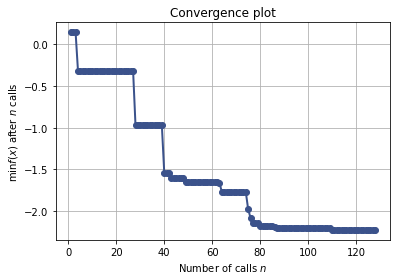

In [15]:
plot_convergence(result);

### Results

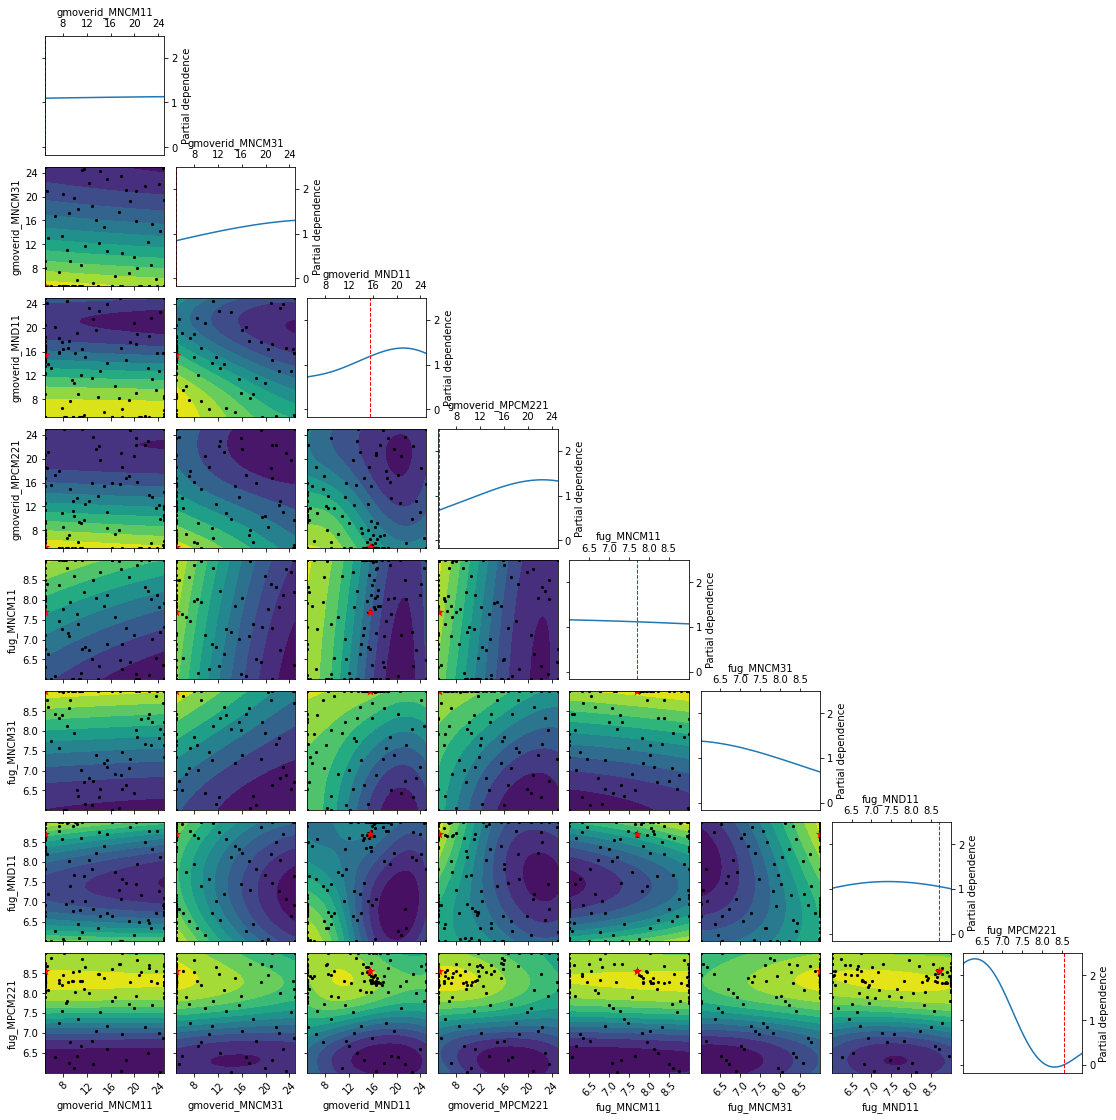

In [16]:
plot_objective(result);

In [17]:
gmoverid = result.x[:4]
fug = [10 ** f for f in result.x[4:]]
sizing = sizing_procedure(I_B0, I_B1, I_B2, *gmoverid, *fug)
performance = {k: v for k,v in ac.evaluate_circuit(sym_amp, sizing).items() if k in target.keys() }

In [18]:
performance

{'cmrr': 118.47157635038275,
 'psrr_n': 62.0645913249612,
 'psrr_p': 80.6070582398069,
 'ugbw': 7870258.928804524,
 'sr_r': 4519333.264808021,
 'voff_sys': -0.0005646409586138275,
 'sr_f': -4471966.636784159,
 'a_0': 60.696106848659774,
 'gm': -37.38030155782086,
 'voff_stat': 0.004712224760521198,
 'pm': 80.02528004003626}